In [ ]:
import rasterio
from shapely.geometry import mapping
import os
import rasterio.mask
from rasterio.enums import Resampling
from rasterio.warp import reproject, Resampling
from rasterio import features
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import uniform_filter
import elevation
import tempfile
import seaborn as sns
import osmnx as ox
import pyrosm
from src.utils import DATA_DIR, KILOMETERS_OFFSHORE

/tmp/ipykernel_10763/3835255930.py:8: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-5zzs2o5r because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to

In [2]:
plt.style.use('dark_background')

## load data

In [3]:
brazil = gpd.read_file(f'{DATA_DIR}/brazil.geojson')                            # Brazil's shape
offshore = gpd.read_file(f'{DATA_DIR}/offshore.geojson')                        # Offshore shape (constructed by adding 100km buffer to Brazil's shape)

In [19]:
def load_raster(fp, area=brazil.union(offshore)):
    """
    Loads raster data and crops it to the area of interest.
    """
    if fp.startswith('meterology'):
        geometry = [mapping(polygon) for polygon in area.geometry]
        with rasterio.open(f"{DATA_DIR}/{fp}") as src:
            out_image, out_transform = rasterio.mask.mask(src, geometry, crop=True)
            out_image = out_image[0]
            out_meta = src.meta
    else:
        with rasterio.open(f"{DATA_DIR}/{fp}") as src:
            out_image = src.read(1)
            out_transform = src.transform
            out_meta = src.meta
    return out_image, out_transform, out_meta

In [20]:
# metrological data
power_density, power_density_transform, power_density_meta = load_raster(f'meterology/gwa3_250_powerdensity_100m.tif')
wind_speed, wind_speed_transform, wind_speed_meta = load_raster(f'meterology/gwa3_250_windspeed_100m.tif')


In [21]:
# population data
population, population_transform, population_meta = load_raster(f'demography/bra_pd_2020_1km.tif')
population[ population < 0 ] = 0

In [22]:
# topography data
topography, topography_transform, topography_meta = load_raster('topography/brazil_dem.tif', brazil)
slope, slope_transform, slope_meta = load_raster('topography/slope.tif', brazil)
roughness, roughness_transform, roughness_meta = load_raster('topography/roughness.tif', brazil)

## process data

In [23]:
def get_state_geometry(state):
    """
    state: state name
    return: shapely geometry of state
    """
    boundary_gdf = ox.geocode_to_gdf(state)
    return boundary_gdf

In [24]:
def make_mask(raster, raster_transform, area):  # shape is either brazil, offshore, both, or a state
    return features.rasterize(((geom, 1) for geom in area.geometry), out_shape=raster.shape, transform=raster_transform, fill=0, default_value=1)

In [25]:
def get_bounding_box(matrix):
    """
    matrix: numpy array
    return: bounding box of matrix
    """
    x = np.argwhere(matrix)
    x0, y0 = x.min(axis=0)
    x1, y1 = x.max(axis=0) + 1
    return x0, y0, x1, y1

In [26]:
def plot_area(area, title):
    """
    area: np array of area
    box: pd row with bounding box coordinates
    title: title of plot
    """
    plt.figure(figsize=(10, 10))
    xmin, ymin, xmax, ymax = get_bounding_box(area)
    plt.imshow(area[xmin:xmax, ymin:ymax], cmap='gray')
    plt.title(title)
    plt.show()

mask = make_mask(roughness, roughness_transform, get_state_geometry('Rio de Janeiro, Brazil'))
bounds = get_state_geometry('Rio de Janeiro, Brazil').total_bounds
plot_area(roughness * mask, 'Rio de Janeiro, Brazil')


: 

: 

In [23]:
def scale_and_crop_raster(src_array, src_transform, src_crs, target_transform, target_shape, target_crs):
    # Create a destination array that will receive the reprojected values
    dest_array = np.empty(target_shape, dtype=src_array.dtype)

    # Perform the reprojection
    reproject(
        source=src_array,
        destination=dest_array,
        src_transform=src_transform,
        src_crs=src_crs,
        dst_transform=target_transform,
        dst_crs=target_crs,
        resampling=Resampling.nearest
    )

    return dest_array


In [175]:
# down scale to 1km (due to memory constraints). Analysis will improve if we upscale to topology, but this is a good start
# power_density = scale_and_crop_raster(power_density, power_density_transform, power_density_meta['crs'], population_transform, population.shape, population_meta['crs'])
# wind_speed = scale_and_crop_raster(wind_speed, wind_speed_transform, wind_speed_meta['crs'], population_transform, population.shape, population_meta['crs'])
# roughness = scale_and_crop_raster(roughness, roughness_transform, roughness_meta['crs'], population_transform, population.shape, population_meta['crs'])
# slope = scale_and_crop_raster(slope, slope_transform, slope_meta['crs'], population_transform, population.shape, population_meta['crs'])

In [176]:
# down scale to 1km (due to memory constraints). Analysis will improve if we upscale to topology, but this is a good start
small_roughness = scale_and_crop_raster(roughness, roughness_transform, roughness_meta['crs'], wind_speed_transform, wind_speed.shape, wind_speed_meta['crs'])
small_slope = scale_and_crop_raster(slope, slope_transform, slope_meta['crs'], wind_speed_transform, wind_speed.shape, wind_speed_meta['crs'])
small_population = scale_and_crop_raster(population, population_transform, population_meta['crs'], wind_speed_transform, wind_speed.shape, wind_speed_meta['crs'])

KeyboardInterrupt: 

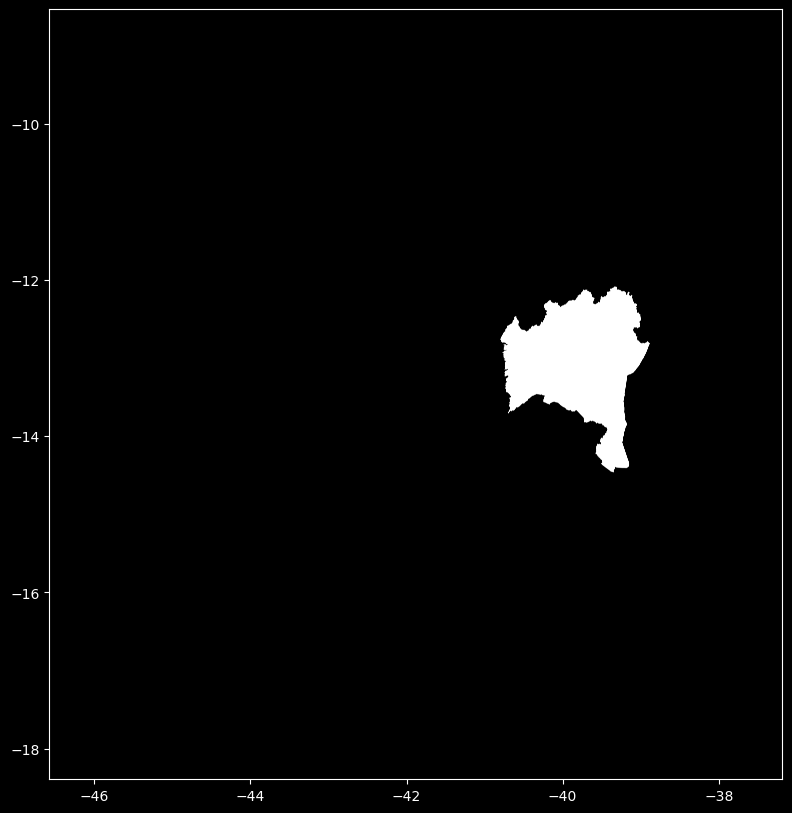

In [190]:
state = get_state_geometry('Bahia, Brazil')
area_mask = make_mask(wind_speed, wind_speed_transform, state)
area_box = state.bounds.iloc[0]
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(area_mask, cmap='gray', extent=[area_box.minx, area_box.maxx, area_box.miny, area_box.maxy])
plt.show()



<Axes: >

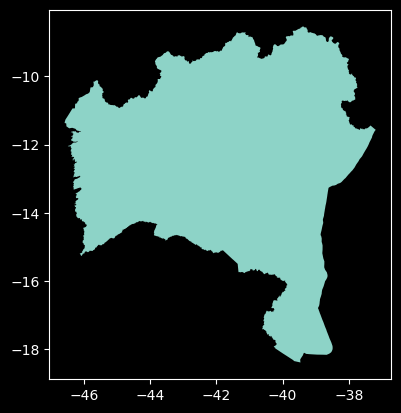

In [193]:
state.plot()

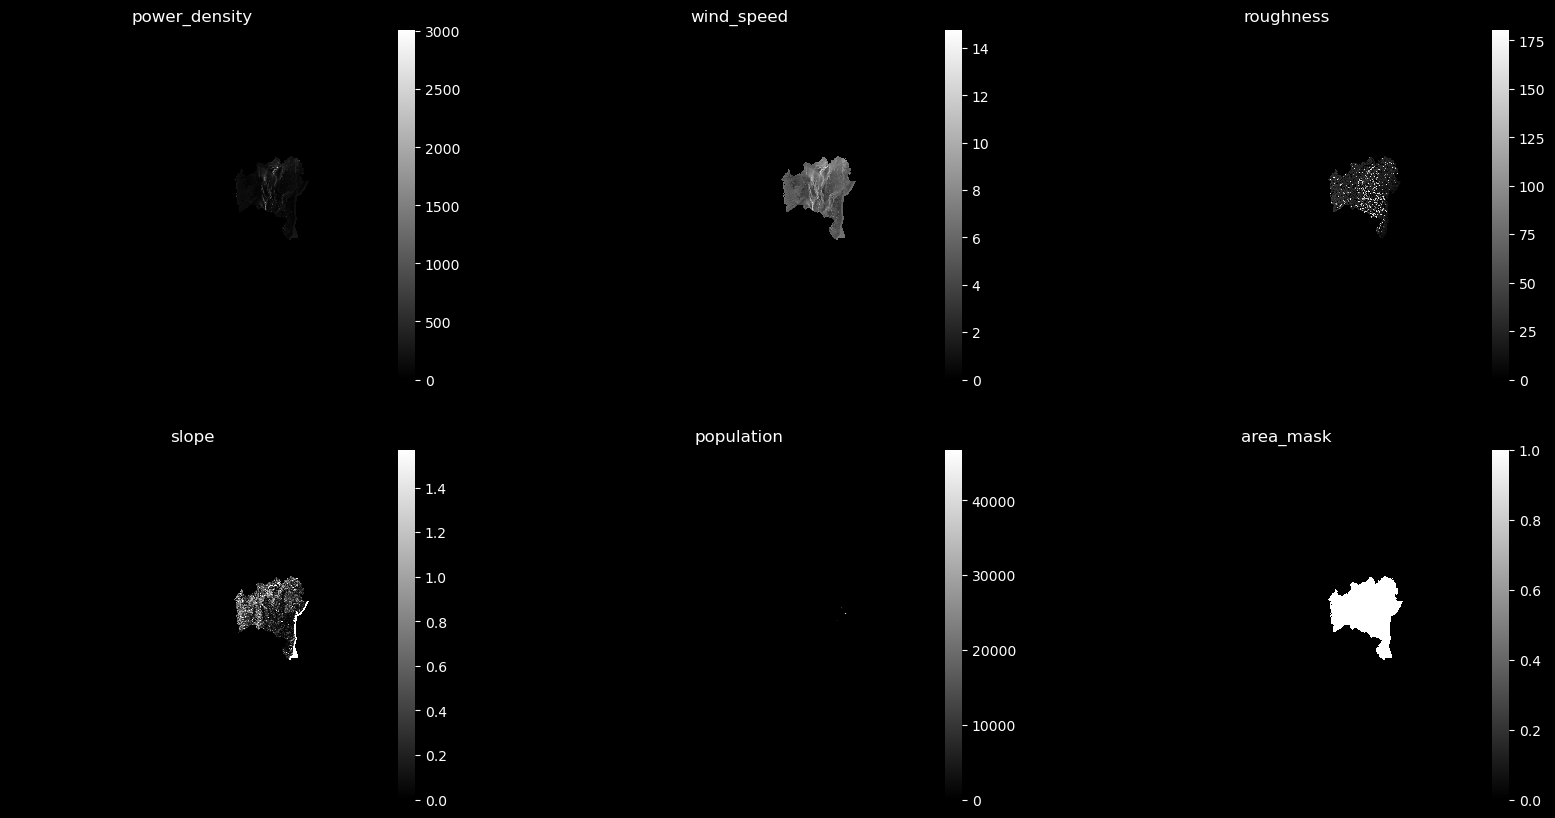

In [144]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for ax, raster, title in zip(axes.flatten(),
                            [power_density, wind_speed, small_roughness, small_slope, small_population, area_mask],
                            ['power_density', 'wind_speed', 'roughness', 'slope', 'population', 'area_mask']):
    # all outside of population mask is nan
    plot_data = (raster * area_mask)[::10, ::10]
    ax.set_title(title)
    sns.heatmap(plot_data, ax=ax, cmap='gray')
    ax.axis('off')
plt.show()


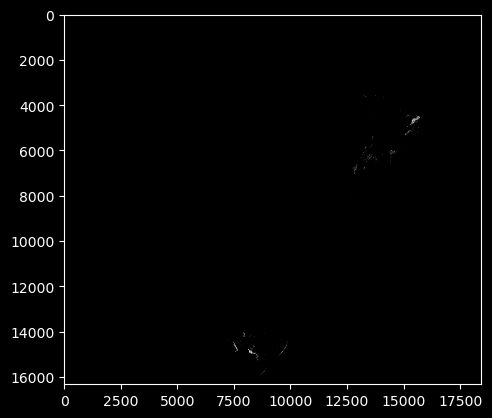

In [125]:
onshore_mask = (small_population < 10) & (area_mask == 1) & (wind_speed < 12) & (wind_speed > 8) & (small_roughness < 30) & (small_slope < 1)
onshore_mask = uniform_filter(onshore_mask, size=2)
plt.imshow(onshore_mask, cmap='gray')

In [124]:
np.sum(onshore_mask) / np.sum(brazil_mask)

0.0003206713722059895

In [102]:
# sns.heatmap(roughness[::20, ::20], cmap='gray')
# 0.99 quantile of rougness (excluding nan)
np.quantile(slope.flatten()[np.where((slope * brazil_mask).flatten() > 0)], 0.20)

0.11534264915034131

### infrastructure | vector

In [55]:
# infrastructure data
landuse = gpd.read_file(f'{DATA_DIR}/infrastructure/landuse.csv', GEOM_POSSIBLE_NAMES="location", KEEP_GEOM_COLUMNS="NO")
power = gpd.read_file(f'{DATA_DIR}/infrastructure/power.csv', GEOM_POSSIBLE_NAMES="location", KEEP_GEOM_COLUMNS="NO")
powergeneration = gpd.read_file(f'{DATA_DIR}/infrastructure/powergeneration.csv', GEOM_POSSIBLE_NAMES="location", KEEP_GEOM_COLUMNS="NO")

## exploration

<Axes: >

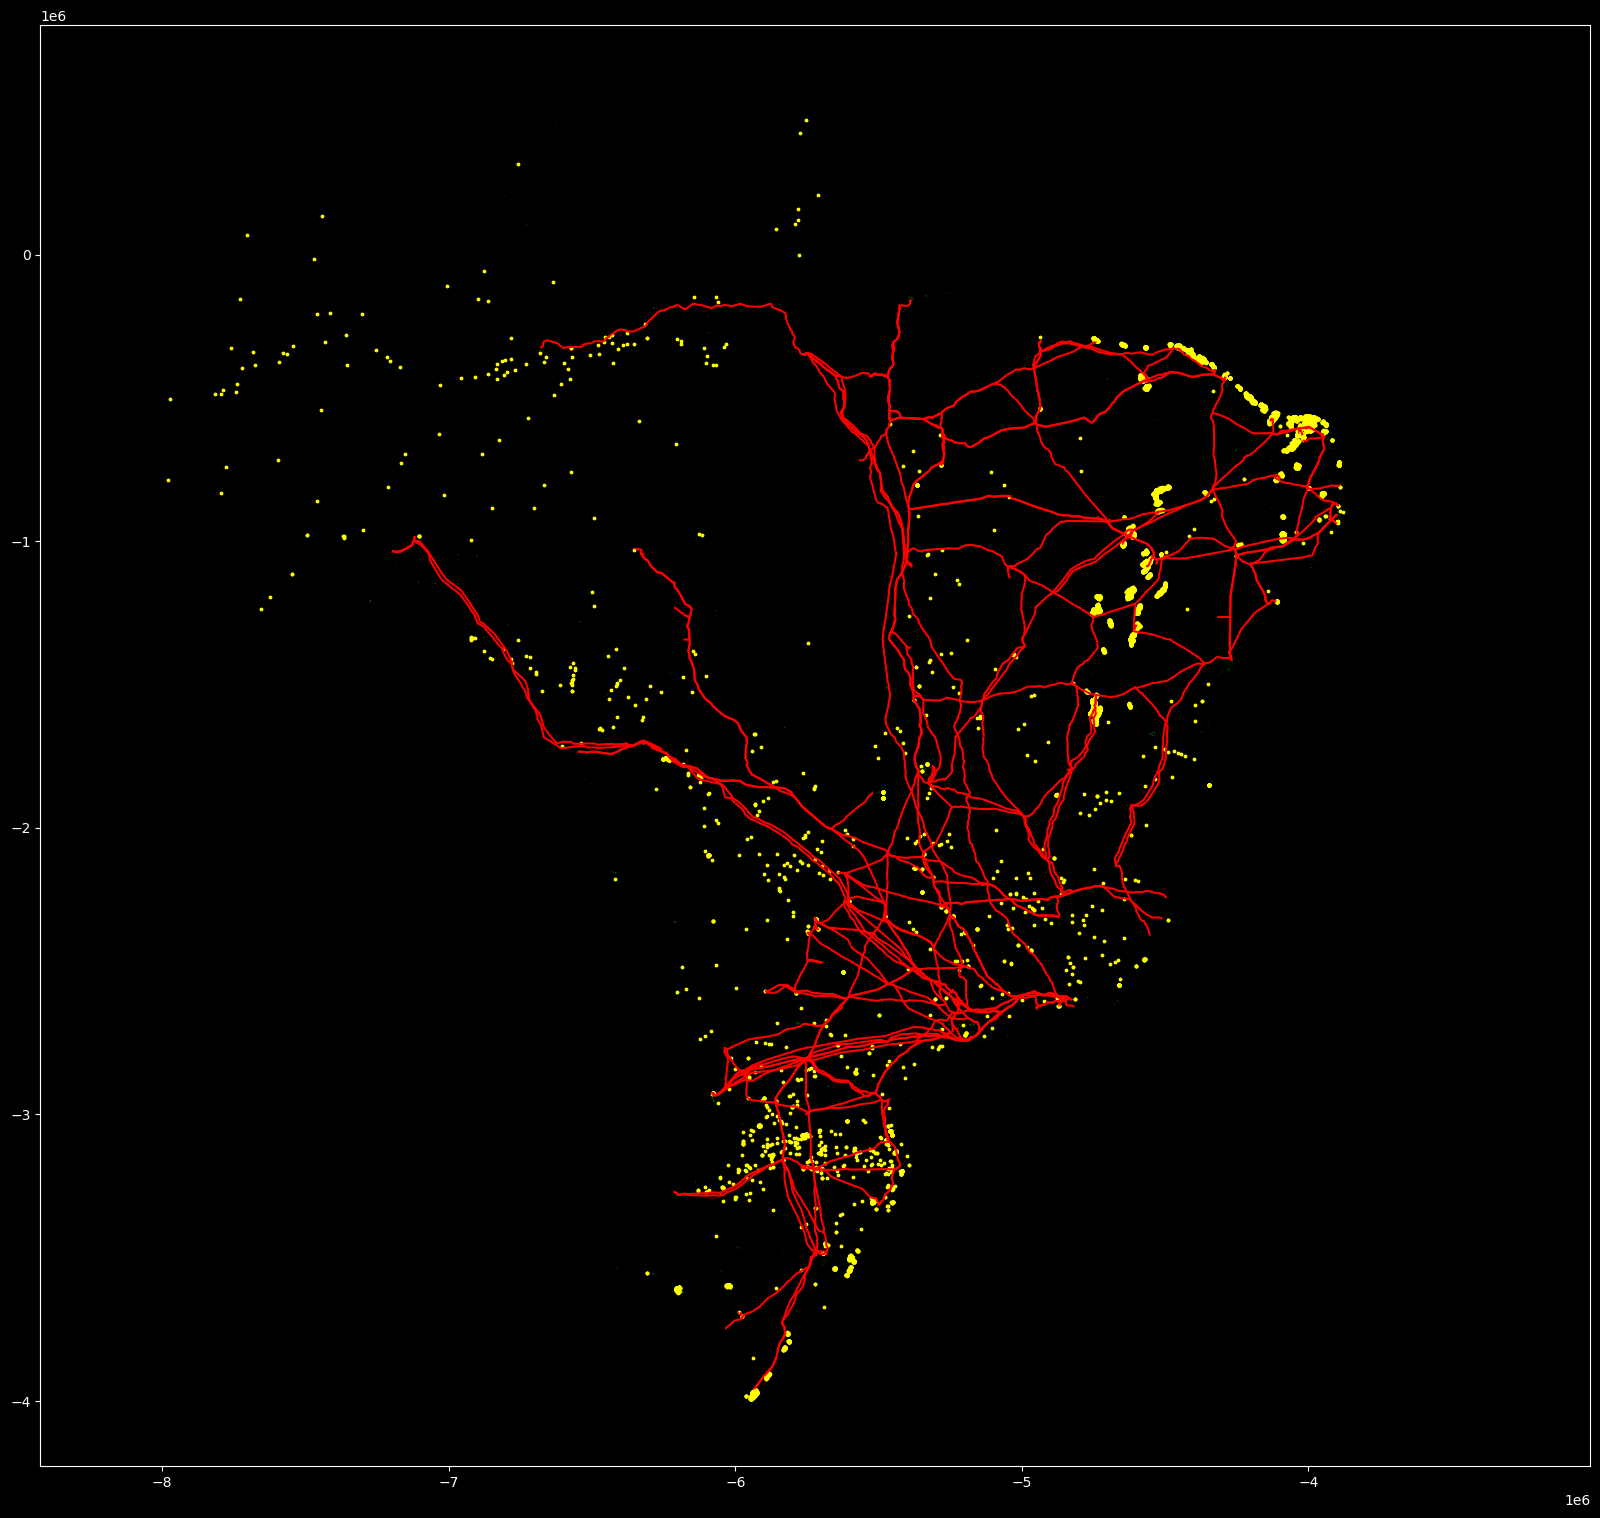

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
landuse.plot(ax=ax, color='green', markersize=3)
power.plot(ax=ax, color='red', markersize=3)
powergeneration.plot(ax=ax, color='yellow', markersize=3)

## constraints

In [ ]:
# this metereology mask is rater based and has the crs of the raster
metereology_mask = (wind_speed > 8) & (wind_speed < 12) & (power_density > 200)

In [ ]:

population_mask = population_density['Z'] < 1

In [21]:
wind_speed

array([[-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       ...,
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.]], dtype=float32)

## optimization